# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [ ]:
# Import necessary libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from joblib import Parallel, delayed
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


In [ ]:
# if using google colab -> mount drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [ ]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [ ]:
## Load data from 'data.csv' into a DataFrame 'df'
df = pd.read_csv("/content/drive/MyDrive/MINI-PROJECT/icml_face_data.csv") # df = pd.read_csv(../data/icml_face_data.csv) 

## Calculate and display the number of missing values in each column
df.isnull().sum()

emotion    0
pixels     0
dtype: int64

In [ ]:
# Count the occurrences of each unique value in the 'emotion' column
df['emotion'].value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [ ]:
# Display the first 5 rows of the DataFrame
df = pd.concat([df.iloc[0:10000], df.iloc[15000:25000]], ignore_index=True)
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [ ]:
## parsing data here
images, labels = parse_data(df)

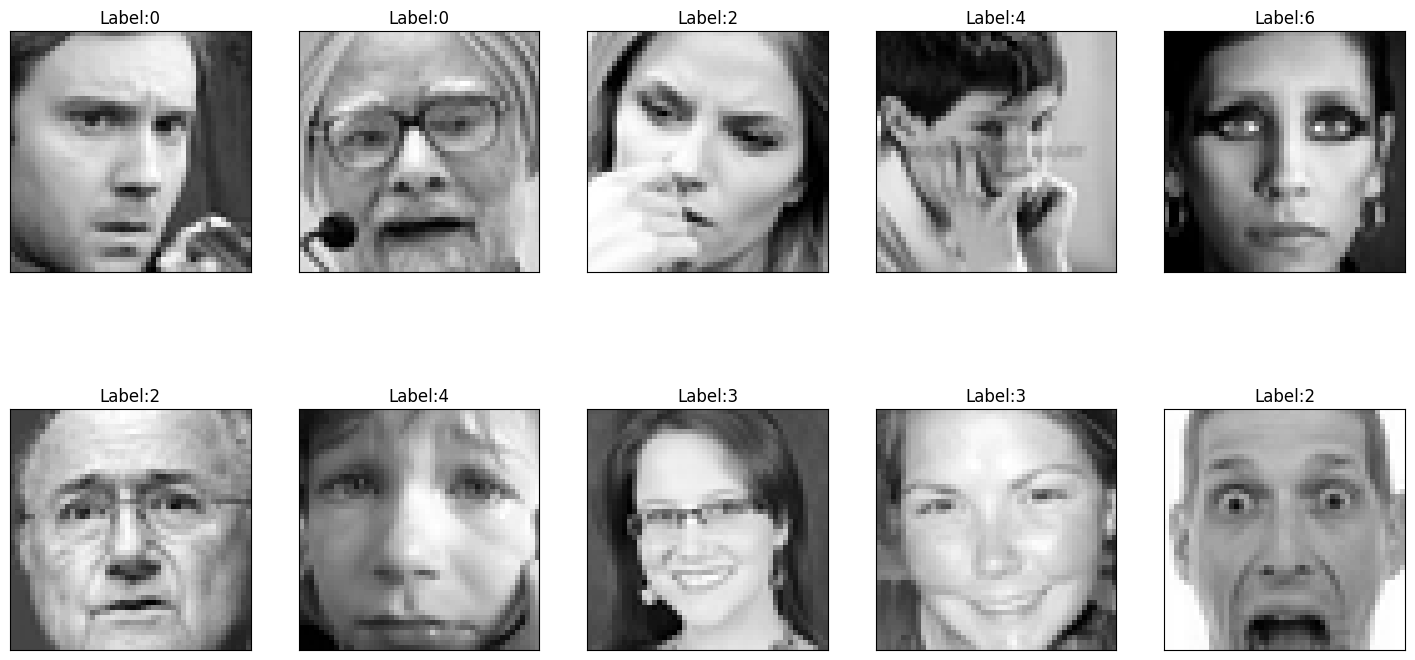

In [ ]:
## showing images here
show_img(images, labels)

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

Dữ liệu có thể được hiển thị dưới dạng biểu đồ 2D bằng cách sử dụng hai thành phần chính đầu tiên. Đoạn mã trên trình bày cách chiếu dữ liệu lên hai thành phần chính và trực quan hóa nó bằng biểu đồ phân tán.

In [ ]:
# Get the number of samples, height, and width from the shape of the images array
n_samples, h, w = images.shape

# Reshape the images array to have each image as a flat array of pixels
X = images.reshape(n_samples, h * w)
X

[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 63.  43.  25. ...   4.   7.   5.]
 [ 84.  48.  49. ... 235. 244. 242.]
 [114. 115. 115. ... 125. 106. 116.]]


### Scaled bằng StandardScaler

In [ ]:
# Initialize a StandardScaler to standardize the features
scaler = StandardScaler()

# Fit the scaler to the data and transform it
scaled_data = scaler.fit_transform(X)

In [ ]:
# n_components=2
pca = PCA(n_components=2)

# fits the PCA model to the scaled_data.
pca.fit(scaled_data)

PCA(n_components=2)

In [ ]:
## modify images' array to the appropriate shape
images_pca=pca.transform(X)
print(images_pca.shape)

(20000, 2)


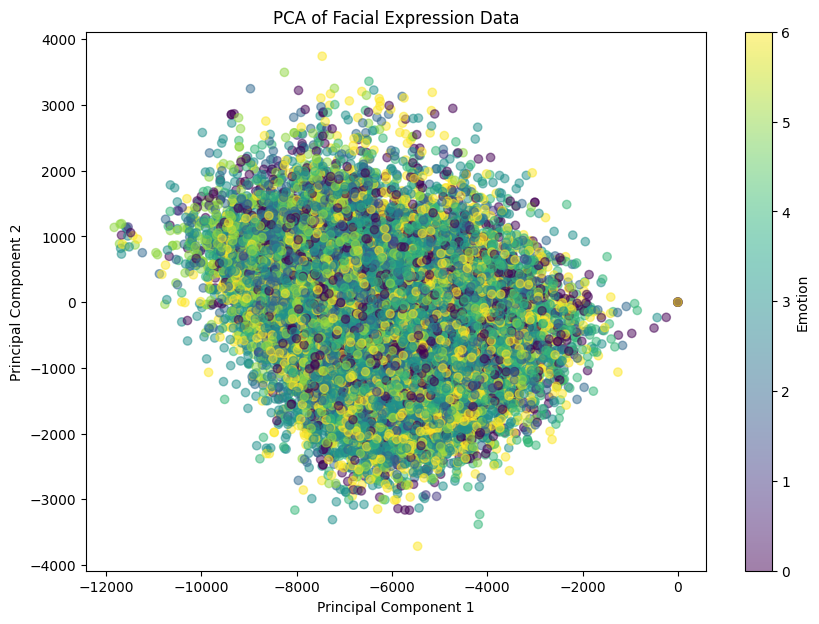

In [ ]:
# Scatter plot of PCA results for facial expression data,
# with emotions color-coded using 'viridis' colormap.
plt.figure(figsize=(10, 7))
scatter = plt.scatter(images_pca[:, 0], images_pca[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, ticks=range(7), label='Emotion')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Facial Expression Data')
plt.show()

### Question 2: How to determine the optimal number of principal components using pca.explained_variance_? Explain your selection process. (2 points)

In [ ]:
# Rescale the data using MinMaxScaler to ensure all features are within the same range.
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(X)

# Fit PCA to the rescaled data.
pca = PCA().fit(X)

In [ ]:
# explained variance of each principal component calculated by PCA.
pca.explained_variance_

array([2.67397878e+06, 9.12836584e+05, 8.76732883e+05, ...,
       3.85175917e+00, 3.64867569e+00, 3.38285471e+00])

In [ ]:
total_variance = np.sum(pca.explained_variance_)

# calculator the ratio explained variance
explained_variance_ratio = pca.explained_variance_ / total_variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# set threhold to find the optimal num components
threshold = 0.9
optimal_num_components = np.argmax(cumulative_variance >= threshold) + 1

print(f"Số components tối ưu: {optimal_num_components}")

Số components tối ưu: 103


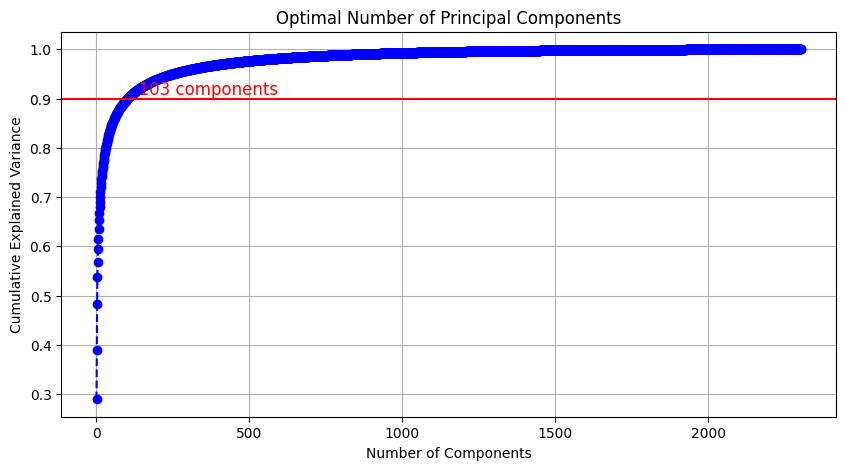

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')

# Add a horizontal line at the threshold level (e.g., 95% of total variance)
plt.axhline(y=threshold, color='r', linestyle='-')

# Mark the intersection point
intersection_x = optimal_num_components
intersection_y = cumulative_variance[optimal_num_components - 1]  # -1 to account for 0-based index
plt.scatter(intersection_x, intersection_y, color='red')  # Mark the intersection point with a red dot
plt.text(intersection_x, intersection_y, f'  {intersection_x} components', color='red', fontsize=12, verticalalignment='bottom')  # Annotate the point

# Label the x-axis as 'Number of Components'
plt.xlabel('Number of Components')

# Label the y-axis as 'Cumulative Explained Variance'
plt.ylabel('Cumulative Explained Variance')

# Add a title to the plot
plt.title('Optimal Number of Principal Components')
plt.grid(True)
plt.show()

Để giữ lại 90% tổng phương sai trong dữ liệu, đường màu đỏ tại mức 90% đại diện cho ngưỡng phương sai với mức thông tin như vậy và ứng với ngưỡng đó thì số components là 103. Thông thường thì thì ta chọn ngường là 95% tuy nhiên với ngưỡng này thì số components là 255 (một số chiều khá lớn và gây ảnh hưởng tới tốc độ chạy của mô hình).

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

In [ ]:
# print the optimail of components
optimal_num_components

103

In [ ]:
# Reshape images for PCA and model input
images_reshaped = images.reshape(images.shape[0], -1)

In [ ]:
# Split data into train/test sets
X_train_orig, X_test_orig, y_train, y_test = train_test_split(images_reshaped, labels, test_size=0.2, random_state=42)

In [ ]:
# Apply PCA and transform the data
pca = PCA(n_components=optimal_num_components)
X_train_pca = pca.fit_transform(X_train_orig)
X_test_pca = pca.transform(X_test_orig)

# Scaled origin data
scaler_orig = StandardScaler()
X_train_orig_scaled = scaler_orig.fit_transform(X_train_orig)
X_test_orig_scaled = scaler_orig.transform(X_test_orig)

# Scaled PCA data
scaler_pca = StandardScaler()
X_train_pca_scaled = scaler_pca.fit_transform(X_train_pca)
X_test_pca_scaled = scaler_pca.transform(X_test_pca)

In [ ]:
# function parallel predict
def parallel_predict(model, data, n_jobs=-1):
    """
    Predict using the given model in parallel across multiple CPU cores.

    Parameters:
    -----------
    model : object
        The predictive model with a `predict` method to apply to data chunks.

    data : array-like of shape (n_samples, n_features)
        The input data to predict on.

    n_jobs : int, default=-1
        Number of CPU cores to use for parallel prediction. 
        If set to -1, it uses all available CPU cores.
    """
    n_splits = n_jobs if n_jobs > 0 else len(data)
    data_splits = np.array_split(data, n_splits)

    def predict_chunk(chunk):
        return model.predict(chunk)

    results = Parallel(n_jobs=n_jobs)(delayed(predict_chunk)(chunk) for chunk in data_splits)
    return np.concatenate(results)

In [ ]:
def calculate_performance(y_pred_orig, y_test):
    """
    Calculate performance metrics such as precision, recall, accuracy, F1 score,
    confusion matrix, and classification report based on predicted and true labels.

    Parameters:
    -----------
    y_pred_orig : array-like of shape (n_samples,)
        Predicted labels or values.

    y_test : array-like of shape (n_samples,)
        Ground truth (correct) target values.
    """
    precision = precision_score(y_test, y_pred_orig, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred_orig, average='macro', zero_division=0)
    accuracy = accuracy_score(y_test, y_pred_orig)
    f1 = f1_score(y_test, y_pred_orig, average='macro', zero_division=0)
    classification = classification_report(y_test, y_pred_orig, zero_division=0)
    confusion = confusion_matrix(y_test, y_pred_orig)

    result = {
        "Precision": precision,
        "Recall": recall,
        "Accurace": accuracy,
        "F1": f1,
        "Confusion matrix": confusion,
        "Classification": classification
    }

    return result

In [ ]:
# set n_jobs
n_jobs = 3

### 1. Logistic Regression

In [ ]:
# Train Logistic Regression model on original data
log_reg_orig = LogisticRegression(max_iter=3500)
log_reg_orig.fit(X_train_orig_scaled, y_train)

# Train Logistic Regression model on PCA transformed data
log_reg_pca = LogisticRegression(max_iter=3500)
log_reg_pca.fit(X_train_pca_scaled, y_train)

# Models trained: log_reg_orig on original data, log_reg_pca on PCA transformed data

LogisticRegression(max_iter=3500)

In [ ]:
print("Evaluation on Original Data:")
y_pred_orig = parallel_predict(log_reg_orig, X_test_orig_scaled, n_jobs=n_jobs)
# y_pred_orig = log_reg_orig.predict(X_test_orig_scaled)
result_logistic_regression_original_data = calculate_performance(y_pred_orig, y_test)
print(result_logistic_regression_original_data["Classification"])

print("Evaluation on PCA Transformed Data:")
y_pred_pca = parallel_predict(log_reg_pca, X_test_pca_scaled, n_jobs=n_jobs)
# y_pred_pca = log_reg_pca.predict(X_test_pca_scaled)
result_logistic_regression_pca_data = calculate_performance(y_pred_pca, y_test)
print(result_logistic_regression_pca_data["Classification"])

Evaluation on Original Data:
              precision    recall  f1-score   support

           0       0.24      0.20      0.22       584
           1       0.05      0.11      0.07        56
           2       0.22      0.21      0.21       568
           3       0.42      0.46      0.44       996
           4       0.27      0.22      0.24       704
           5       0.36      0.40      0.38       415
           6       0.25      0.26      0.26       677

    accuracy                           0.30      4000
   macro avg       0.26      0.27      0.26      4000
weighted avg       0.30      0.30      0.30      4000

Evaluation on PCA Transformed Data:
              precision    recall  f1-score   support

           0       0.37      0.15      0.21       584
           1       0.50      0.02      0.03        56
           2       0.24      0.14      0.18       568
           3       0.42      0.71      0.53       996
           4       0.31      0.27      0.29       704
           5 

In [ ]:
# Hyperparameter tuning using GridSearchCV for Logistic Regression on original data
param_grid = {'C': [0.1, 1], 'solver': ['liblinear', 'lbfgs']}
grid_search_orig_lr = GridSearchCV(LogisticRegression(max_iter=3500), param_grid, cv=2, verbose=2, n_jobs=3)
grid_search_orig_lr.fit(X_train_orig_scaled, y_train)

# Hyperparameter tuning using GridSearchCV for Logistic Regression on PCA transformed data
grid_search_pca_lr = GridSearchCV(LogisticRegression(max_iter=3500), param_grid, cv=2, verbose=2, n_jobs=3)
grid_search_pca_lr.fit(X_train_pca_scaled, y_train)

# Print best parameters found by GridSearchCV
print("Best parameters for original data:", grid_search_orig_lr.best_params_)
print("Best parameters for PCA data:", grid_search_pca_lr.best_params_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END ............................C=0.1, solver=liblinear; total time= 3.5min
[CV] END ..................................C=1, solver=lbfgs; total time= 1.8min
[CV] END ..................................C=1, solver=lbfgs; total time= 1.8min
[CV] END ................................C=0.1, solver=lbfgs; total time=  54.7s
[CV] END ................................C=0.1, solver=lbfgs; total time=  50.9s
[CV] END ..............................C=1, solver=liblinear; total time= 7.8min
[CV] END ............................C=0.1, solver=liblinear; total time= 3.4min
[CV] END ..............................C=1, solver=liblinear; total time= 6.7min
Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best parameters for original data: {'C': 0.1, 'solver': 'liblinear'}
Best parameters for PCA data: {'C': 0.1, 'solver': 'lbfgs'}


In [ ]:
# Evaluate the best models with Original Data
print("Evaluation of best model on Original Data:")
y_pred_orig_logistic_regression = parallel_predict(grid_search_orig_lr.best_estimator_, X_test_orig_scaled, n_jobs=3)
result_logistic_regression_origin_data_grid = calculate_performance(y_pred_orig_logistic_regression, y_test)
print(result_logistic_regression_origin_data_grid["Classification"])

Evaluation of best model on Original Data:
              precision    recall  f1-score   support

           0       0.27      0.19      0.22       584
           1       0.20      0.07      0.11        56
           2       0.24      0.21      0.22       568
           3       0.42      0.57      0.48       996
           4       0.27      0.23      0.25       704
           5       0.39      0.41      0.40       415
           6       0.28      0.30      0.29       677

    accuracy                           0.33      4000
   macro avg       0.30      0.28      0.28      4000
weighted avg       0.32      0.33      0.32      4000



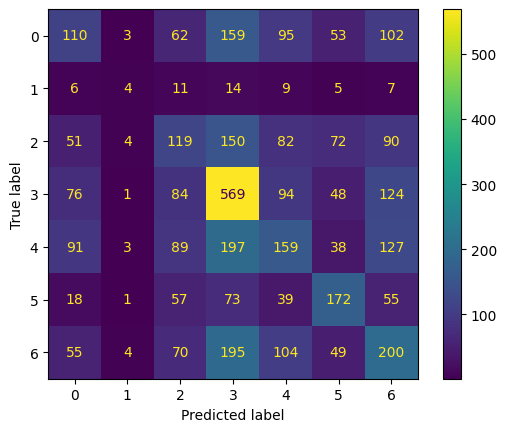

In [ ]:
# Plot confusion matrix for the best Logistic Regression model on original data
ConfusionMatrixDisplay(confusion_matrix=result_logistic_regression_origin_data_grid["Confusion matrix"],
                    display_labels=grid_search_orig_lr.classes_).plot()

In [ ]:
# Evaluate the best models with PCA Data
print("Evaluation of best model on PCA Data:")
y_pred_pca_logistic_regression = parallel_predict(grid_search_pca_lr.best_estimator_, X_test_pca_scaled, n_jobs=3)
result_logistic_regression_pca_data_grid = calculate_performance(y_pred_pca_logistic_regression, y_test)
print(result_logistic_regression_pca_data_grid["Classification"])

Evaluation of best model on PCA Data:
              precision    recall  f1-score   support

           0       0.37      0.15      0.21       584
           1       0.50      0.02      0.03        56
           2       0.24      0.14      0.17       568
           3       0.42      0.71      0.53       996
           4       0.31      0.27      0.29       704
           5       0.42      0.49      0.45       415
           6       0.33      0.34      0.33       677

    accuracy                           0.37      4000
   macro avg       0.37      0.30      0.29      4000
weighted avg       0.36      0.37      0.34      4000



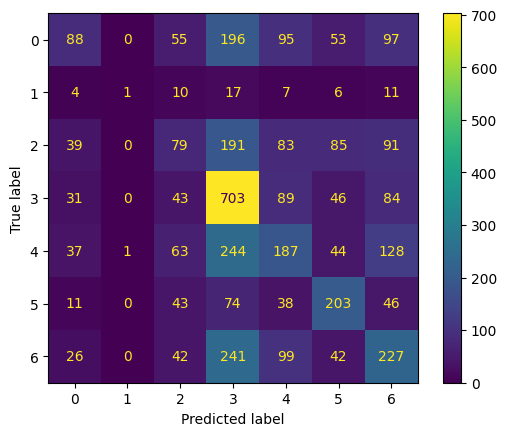

In [ ]:
# Plot confusion matrix for the best Logistic Regression model on PCA transformed data
ConfusionMatrixDisplay(confusion_matrix=result_logistic_regression_pca_data_grid["Confusion matrix"],
                    display_labels=grid_search_pca_lr.classes_).plot()

### 2. SVM

In [ ]:
# Train Support Vector Machine (SVM) model on original data
svm_model = SVC()
svm_model.fit(X_train_orig_scaled, y_train)

SVC()

In [ ]:
# Train Support Vector Machine (SVM) model on PCA transformed data
svm_pca = SVC()
svm_pca.fit(X_train_pca_scaled, y_train)

SVC()

In [ ]:
# Predict using SVM model trained on original data
x_pred_orig = parallel_predict(svm_model, X_train_orig_scaled, n_jobs=n_jobs)
y_pred_orig = parallel_predict(svm_model, X_test_orig_scaled, n_jobs=n_jobs)

In [ ]:
# Evaluate performance on training set using SVM model trained on original data
print("Evaluation on Original Data:")
result_svc_original_data = calculate_performance(x_pred_orig, y_train)
print(result_svc_original_data["Classification"])

Evaluation on Original Data:
              precision    recall  f1-score   support

           0       0.75      0.46      0.57      2212
           1       0.96      0.09      0.16       254
           2       0.71      0.47      0.57      2296
           3       0.61      0.89      0.72      4096
           4       0.58      0.62      0.60      2620
           5       0.77      0.66      0.71      1799
           6       0.62      0.63      0.62      2723

    accuracy                           0.64     16000
   macro avg       0.71      0.54      0.56     16000
weighted avg       0.66      0.64      0.63     16000



In [ ]:
# Evaluate performance on test set using SVM model trained on original data
print("Evaluation on Original Data:")
result_svc_original_data = calculate_performance(y_pred_orig, y_test)
print(result_svc_original_data["Classification"])

Evaluation on Original Data:
              precision    recall  f1-score   support

           0       0.43      0.21      0.28       584
           1       1.00      0.02      0.04        56
           2       0.34      0.21      0.26       568
           3       0.47      0.74      0.58       996
           4       0.38      0.38      0.38       704
           5       0.55      0.51      0.53       415
           6       0.39      0.41      0.40       677

    accuracy                           0.43      4000
   macro avg       0.51      0.35      0.35      4000
weighted avg       0.43      0.43      0.41      4000



In [ ]:
# Predict using SVM model trained on PCA transformed data
x_pred_pca = parallel_predict(svm_pca, X_train_pca_scaled, n_jobs=n_jobs)
y_pred_pca = parallel_predict(svm_pca, X_test_pca_scaled, n_jobs=n_jobs)

In [ ]:
# Evaluate performance on training set using SVM model trained on PCA transformed data
print("Evaluation on PCA Data:")
result_svc_pca_data = calculate_performance(x_pred_pca, y_train)
print(result_svc_pca_data["Classification"])

Evaluation on PCA Data:
              precision    recall  f1-score   support

           0       0.82      0.61      0.70      2212
           1       0.96      0.20      0.33       254
           2       0.84      0.63      0.72      2296
           3       0.69      0.93      0.79      4096
           4       0.70      0.72      0.71      2620
           5       0.88      0.76      0.81      1799
           6       0.72      0.76      0.74      2723

    accuracy                           0.75     16000
   macro avg       0.80      0.66      0.69     16000
weighted avg       0.76      0.75      0.74     16000



In [ ]:
# Evaluate performance on test set using SVM model trained on PCA transformed data
print("Evaluation on PCA Data:")
result_svc_pca_data = calculate_performance(y_pred_pca, y_test)
print(result_svc_pca_data["Classification"])

Evaluation on PCA Data:
              precision    recall  f1-score   support

           0       0.44      0.22      0.30       584
           1       1.00      0.04      0.07        56
           2       0.34      0.23      0.27       568
           3       0.47      0.75      0.58       996
           4       0.37      0.35      0.36       704
           5       0.66      0.54      0.59       415
           6       0.41      0.44      0.42       677

    accuracy                           0.45      4000
   macro avg       0.53      0.37      0.37      4000
weighted avg       0.45      0.45      0.43      4000



=> Từ kết quả được đánh giá trên tập train và tập test theo 2 định dạng  của tập dữ liệu ta thấy được model hoạt động rất tốt trên tập train nhưng không hoạt động tốt trên tập test => model có thể overfiting.
=> Ta dùng  Grid Search, điều chỉnh tham số C, cân bằng dữ liệu và kernel khác để cải thiện hiệu suất của mô hình.

---

In [ ]:
# Define SVM pipeline with hyperparameter grid for both original and PCA transformed data
svm_pipeline = Pipeline(
    [
        ("svc", SVC(random_state=42)),
    ]
)

svm_param_grid = {
    "svc__C": [0.1, 1],
    "svc__gamma": ["scale", 0.001],
    "svc__kernel": ["linear", "rbf"],
}

# GridSearchCV for SVM on original data
grid_search_orig_svc = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_param_grid,
    cv=2,
    n_jobs=n_jobs,
    verbose=1,
)

# GridSearchCV for SVM on PCA transformed data
grid_search_pca_svc = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_param_grid,
    cv=2,
    n_jobs=n_jobs,
    verbose=1,
)

In [ ]:
# Perform GridSearchCV on SVM pipeline with original data
grid_search_orig_svc.fit(X_train_orig_scaled, y_train)
print("Best parameters:", grid_search_orig_svc.best_params_)
print("Best score: ", grid_search_orig_svc.best_score_)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best parameters: {'svc__C': 1, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Best score:  0.4060625


In [ ]:
# Perform GridSearchCV on SVM pipeline with PCA transformed data
grid_search_pca_svc.fit(X_train_pca_scaled, y_train)
print("Best parameters:", grid_search_pca_svc.best_params_)
print("Best score: ", grid_search_pca_svc.best_score_)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best parameters: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best score:  0.408875


In [ ]:
# Evaluate the best models with Original Data (train)
print("Evaluation of best model on Original Data:")
x_pred_orig_svm = parallel_predict(grid_search_orig_svc.best_estimator_, X_train_orig_scaled, n_jobs=n_jobs)
result_svc_origin_data_grid_train = calculate_performance(x_pred_orig_svm, y_train)
print(result_svc_origin_data_grid_train["Classification"])

Evaluation of best model on Original Data:
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      2212
           1       0.99      0.41      0.58       254
           2       0.92      0.80      0.86      2296
           3       0.81      0.97      0.88      4096
           4       0.84      0.87      0.85      2620
           5       0.93      0.85      0.89      1799
           6       0.85      0.87      0.86      2723

    accuracy                           0.87     16000
   macro avg       0.90      0.79      0.83     16000
weighted avg       0.87      0.87      0.86     16000



In [ ]:
# Evaluate the best models with Original Data (test)
print("Evaluation of best model on Original Data:")
y_pred_orig_svm = parallel_predict(grid_search_orig_svc.best_estimator_, X_test_orig_scaled, n_jobs=n_jobs)
result_svc_origin_data_grid_test = calculate_performance(y_pred_orig_svm, y_test)
print(result_svc_origin_data_grid_test["Classification"])

Evaluation of best model on Original Data:
              precision    recall  f1-score   support

           0       0.49      0.23      0.31       584
           1       1.00      0.09      0.16        56
           2       0.40      0.26      0.31       568
           3       0.47      0.77      0.59       996
           4       0.36      0.38      0.37       704
           5       0.62      0.52      0.57       415
           6       0.41      0.41      0.41       677

    accuracy                           0.45      4000
   macro avg       0.54      0.38      0.39      4000
weighted avg       0.46      0.45      0.43      4000



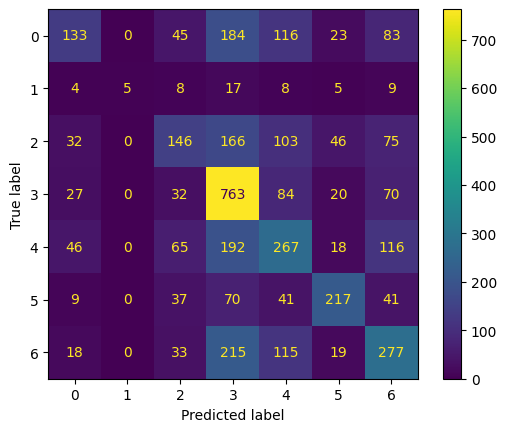

In [ ]:
# Plot confusion matrix for the best SVM model on origin data
ConfusionMatrixDisplay(confusion_matrix=result_svc_origin_data_grid_test["Confusion matrix"],
                    display_labels=grid_search_orig_svc.classes_).plot()

In [ ]:
# Evaluate the best models with PCA Data (train)
print("Evaluation of best model on PCA Data:")
x_pred_pca_svm = parallel_predict(grid_search_pca_svc.best_estimator_, X_train_pca_scaled, n_jobs=n_jobs)
result_svc_pca_data_grid_train = calculate_performance(x_pred_pca_svm, y_train)
print(result_svc_pca_data_grid_train["Classification"])

Evaluation of best model on PCA Data:
              precision    recall  f1-score   support

           0       0.82      0.61      0.70      2212
           1       0.96      0.20      0.33       254
           2       0.84      0.63      0.72      2296
           3       0.69      0.93      0.79      4096
           4       0.70      0.72      0.71      2620
           5       0.88      0.76      0.81      1799
           6       0.72      0.76      0.74      2723

    accuracy                           0.75     16000
   macro avg       0.80      0.66      0.69     16000
weighted avg       0.76      0.75      0.74     16000



In [ ]:
# Evaluate the best models with PCA Data (test)
print("Evaluation of best model on PCA Data:")
y_pred_pca_svm = parallel_predict(grid_search_pca_svc.best_estimator_, X_test_pca_scaled, n_jobs=n_jobs)
result_svc_pca_data_grid_test = calculate_performance(y_pred_pca_svm, y_test)
print(result_svc_pca_data_grid_test["Classification"])

Evaluation of best model on PCA Data:
              precision    recall  f1-score   support

           0       0.44      0.22      0.30       584
           1       1.00      0.04      0.07        56
           2       0.34      0.23      0.27       568
           3       0.47      0.75      0.58       996
           4       0.37      0.35      0.36       704
           5       0.66      0.54      0.59       415
           6       0.41      0.44      0.42       677

    accuracy                           0.45      4000
   macro avg       0.53      0.37      0.37      4000
weighted avg       0.45      0.45      0.43      4000



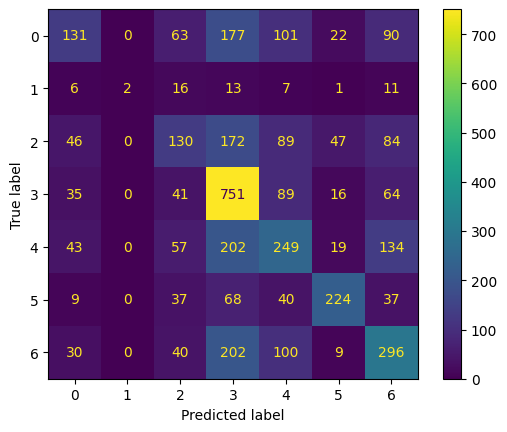

In [ ]:
# Plot confusion matrix for the best SVM model on PCA transformed data
ConfusionMatrixDisplay(confusion_matrix=result_svc_pca_data_grid_test["Confusion matrix"],
                    display_labels=grid_search_pca_svc.classes_).plot()

### 3. MLP

In [ ]:
# Train MLP classifier on original data
mlp_origin = MLPClassifier(max_iter=1000)
mlp_origin.fit(X_train_orig_scaled, y_train)

MLPClassifier(max_iter=1000)

In [ ]:
# Train MLP classifier on PCA transformed data
mlp_pca = MLPClassifier(max_iter=1000)
mlp_pca.fit(X_train_pca_scaled, y_train)

MLPClassifier(max_iter=1000)

In [ ]:
# Predict using MLP classifier trained on original data
y_pred_orig = parallel_predict(mlp_origin, X_test_orig_scaled, n_jobs=n_jobs)

In [ ]:
# Evaluate performance on test set using MLP classifier trained on original data
print("Evaluation on Original Data:")
result_mlp_original_data = calculate_performance(y_pred_orig, y_test)
print(result_mlp_original_data["Classification"])

Evaluation on Original Data:
              precision    recall  f1-score   support

           0       0.30      0.23      0.26       584
           1       0.13      0.18      0.15        56
           2       0.30      0.29      0.29       568
           3       0.56      0.52      0.54       996
           4       0.28      0.32      0.30       704
           5       0.46      0.50      0.48       415
           6       0.35      0.39      0.37       677

    accuracy                           0.38      4000
   macro avg       0.34      0.35      0.34      4000
weighted avg       0.38      0.38      0.38      4000



In [ ]:
# Predict using MLP classifier trained on PCA transformed data
y_pred_pca = parallel_predict(mlp_pca, X_test_pca_scaled, n_jobs=n_jobs)

In [ ]:
# Evaluate performance on test set using MLP classifier trained on PCA transformed data
print("Evaluation on PCA Data:")
result_mlp_pca_data = calculate_performance(y_pred_pca, y_test)
print(result_mlp_pca_data["Classification"])

Evaluation on PCA Data:
              precision    recall  f1-score   support

           0       0.27      0.24      0.25       584
           1       0.15      0.14      0.15        56
           2       0.24      0.23      0.24       568
           3       0.51      0.51      0.51       996
           4       0.28      0.27      0.28       704
           5       0.40      0.52      0.45       415
           6       0.32      0.31      0.32       677

    accuracy                           0.35      4000
   macro avg       0.31      0.32      0.31      4000
weighted avg       0.35      0.35      0.35      4000



---

In [ ]:
# Define pipeline with SMOTE and MLP classifier, and set hyperparameter grid
pipeline = Pipeline([
    ('smote', SMOTE()),
    ('mlp', MLPClassifier(max_iter=3500))
])


param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'mlp__alpha': [0.01, 0.001]
}

# GridSearchCV for MLP on original data
grid_search_origin_mlp = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=n_jobs, verbose=1)
grid_search_origin_mlp.fit(X_train_orig_scaled, y_train)

# GridSearchCV for MLP on PCA transformed data
grid_search_pca_mlp = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=n_jobs, verbose=1)
grid_search_pca_mlp.fit(X_train_pca_scaled, y_train)

# Print best parameters found by GridSearchCV
print("Best parameters for original data:", grid_search_origin_mlp.best_params_)
print("Best parameters for PCA data:", grid_search_pca_mlp.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters for original data: {'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,)}
Best parameters for PCA data: {'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,)}


In [ ]:
# Print best cross-validation scores for MLP on original and PCA data
print("Best parameters for original data:", grid_search_origin_mlp.best_score_)
print("Best parameters for PCA data:", grid_search_pca_mlp.best_score_)

Best parameters for original data: 0.37043735837164365
Best parameters for PCA data: 0.3321878385115605


In [ ]:
# Evaluate the best model selected by GridSearchCV on Original Data
print("Evaluation of best model on Original Data:")
y_pred_orig_mlp = parallel_predict(grid_search_origin_mlp.best_estimator_, X_test_orig_scaled, n_jobs=n_jobs)
result_mlp_origin_data_grid = calculate_performance(y_pred_orig_mlp, y_test)
print(result_mlp_origin_data_grid["Classification"])

Evaluation of best model on Original Data:
              precision    recall  f1-score   support

           0       0.27      0.24      0.25       584
           1       0.16      0.18      0.17        56
           2       0.29      0.30      0.29       568
           3       0.53      0.54      0.54       996
           4       0.30      0.32      0.31       704
           5       0.53      0.49      0.51       415
           6       0.35      0.35      0.35       677

    accuracy                           0.38      4000
   macro avg       0.35      0.35      0.35      4000
weighted avg       0.38      0.38      0.38      4000



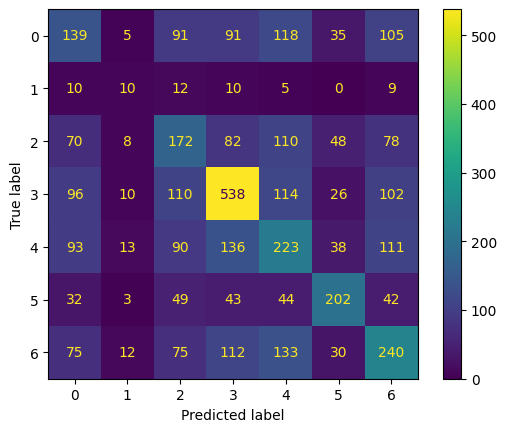

In [ ]:
# Plot confusion matrix for the best MLP model on original data
ConfusionMatrixDisplay(confusion_matrix=result_mlp_origin_data_grid["Confusion matrix"],
                    display_labels=grid_search_origin_mlp.classes_).plot()

In [ ]:
# Evaluate the best model selected by GridSearchCV on PCA Data
print("Evaluation of best model on PCA Data:")
y_pred_pca_mlp = parallel_predict(grid_search_pca_mlp.best_estimator_, X_test_pca_scaled, n_jobs=n_jobs)
result_mlp_pca_data_grid = calculate_performance(y_pred_pca_mlp, y_test)
print(result_mlp_pca_data_grid["Classification"])

Evaluation of best model on PCA Data:
              precision    recall  f1-score   support

           0       0.28      0.31      0.29       584
           1       0.12      0.20      0.15        56
           2       0.23      0.24      0.23       568
           3       0.54      0.48      0.51       996
           4       0.28      0.25      0.26       704
           5       0.40      0.54      0.46       415
           6       0.37      0.32      0.34       677

    accuracy                           0.36      4000
   macro avg       0.32      0.33      0.32      4000
weighted avg       0.36      0.36      0.36      4000



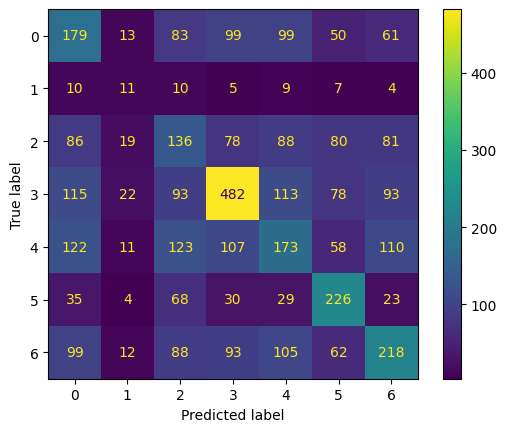

In [ ]:
# Plot confusion matrix for the best MLP model on PCA data
ConfusionMatrixDisplay(confusion_matrix=result_mlp_pca_data_grid["Confusion matrix"],
                    display_labels=grid_search_pca_mlp.classes_).plot()

### 4. Decision Tree - Random Forest Regressor

In [ ]:
# Train Random Forest classifier on original data
random_forest_origin = RandomForestClassifier()
random_forest_origin.fit(X_train_orig_scaled, y_train)

RandomForestClassifier()

In [ ]:
# Train Random Forest classifier on PCA transformed data
random_forest_pca = RandomForestClassifier()
random_forest_pca.fit(X_train_pca_scaled, y_train)

RandomForestClassifier()

In [ ]:
# Predict using Random Forest classifier trained on original data
y_pred_orig = parallel_predict(random_forest_origin, X_test_orig_scaled, n_jobs=n_jobs)

In [ ]:
# Evaluate performance on test set using Random Forest classifier trained on original data
print("Evaluation on Original Data:")
result_random_forest_original_data = calculate_performance(y_pred_orig, y_test)
print(result_random_forest_original_data["Classification"])

Evaluation on Original Data:
              precision    recall  f1-score   support

           0       0.42      0.18      0.26       584
           1       1.00      0.16      0.28        56
           2       0.37      0.24      0.29       568
           3       0.42      0.76      0.54       996
           4       0.35      0.30      0.32       704
           5       0.60      0.55      0.57       415
           6       0.41      0.36      0.38       677

    accuracy                           0.42      4000
   macro avg       0.51      0.36      0.38      4000
weighted avg       0.43      0.42      0.40      4000



In [ ]:
# Predict using Random Forest classifier trained on PCA transformed data
y_pred_pca = parallel_predict(random_forest_pca, X_test_pca_scaled, n_jobs=n_jobs)

In [ ]:
# Evaluate performance on test set using Random Forest classifier trained on PCA transformed data
print("Evaluation on PCA Data:")
result_random_forest_pca_data = calculate_performance(y_pred_pca, y_test)
print(result_random_forest_pca_data["Classification"])

Evaluation on PCA Data:
              precision    recall  f1-score   support

           0       0.41      0.14      0.21       584
           1       1.00      0.12      0.22        56
           2       0.38      0.20      0.26       568
           3       0.36      0.82      0.50       996
           4       0.36      0.20      0.26       704
           5       0.67      0.47      0.55       415
           6       0.38      0.30      0.33       677

    accuracy                           0.39      4000
   macro avg       0.51      0.32      0.33      4000
weighted avg       0.42      0.39      0.36      4000



---

In [ ]:
# Define pipeline with Random Forest classifier and set hyperparameter grid for both original and PCA data
pipeline = Pipeline([
    ('randomforestclassifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'randomforestclassifier__n_estimators': [200, 500],
    'randomforestclassifier__criterion': ['gini', 'entropy']
}

# GridSearchCV for Random Forest on original data
grid_search_origin_rf = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=n_jobs, verbose=1)
grid_search_origin_rf.fit(X_train_orig_scaled, y_train)

# GridSearchCV for Random Forest on PCA transformed data
grid_search_pca_rf = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=n_jobs, verbose=1)
grid_search_pca_rf.fit(X_train_pca_scaled, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=3,
             param_grid={'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__n_estimators': [200, 500]},
             verbose=1)

In [ ]:
# Print best parameters found by GridSearchCV for Random Forest on original and PCA data
print("Best parameters for original data:", grid_search_origin_rf.best_params_)
print("Best parameters for PCA data:", grid_search_pca_rf.best_params_)

Best parameters for original data: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 500}
Best parameters for PCA data: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 500}


In [ ]:
# Print best scores for Random Forest on original and PCA data
print("Best parameters for original data:", grid_search_origin_rf.best_score_)
print("Best parameters for PCA data:", grid_search_pca_rf.best_score_)

Best parameters for original data: 0.4208122025249375
Best parameters for PCA data: 0.38687467882378196


In [ ]:
# Evaluate the best Random Forest model selected by GridSearchCV on Original Data
print("Evaluation of best model on Original Data:")
y_pred_orig_random_forest = parallel_predict(grid_search_origin_rf.best_estimator_, X_test_orig_scaled, n_jobs=n_jobs)
result_random_forest_origin_data_grid = calculate_performance(y_pred_orig_random_forest, y_test)
print(result_random_forest_origin_data_grid["Classification"])

Evaluation of best model on Original Data:
              precision    recall  f1-score   support

           0       0.58      0.15      0.24       584
           1       1.00      0.11      0.19        56
           2       0.44      0.23      0.30       568
           3       0.42      0.81      0.55       996
           4       0.36      0.33      0.35       704
           5       0.59      0.57      0.58       415
           6       0.42      0.36      0.38       677

    accuracy                           0.44      4000
   macro avg       0.54      0.37      0.37      4000
weighted avg       0.46      0.44      0.40      4000



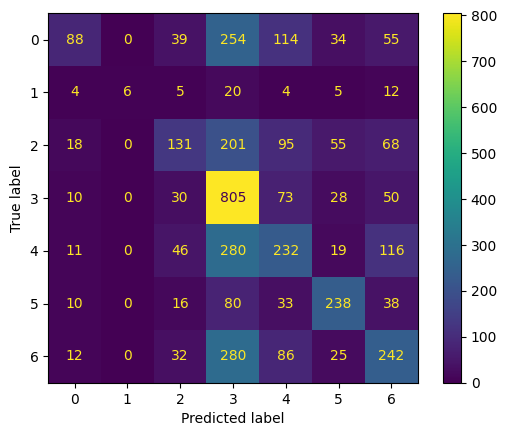

In [ ]:
# Plot confusion matrix for the best Random Forest model on original data
ConfusionMatrixDisplay(confusion_matrix=result_random_forest_origin_data_grid["Confusion matrix"],
                    display_labels=grid_search_origin_rf.classes_).plot()

In [ ]:
# Evaluate the best Random Forest model selected by GridSearchCV on PCA Data
print("Evaluation of best model on PCA Data:")
y_pred_pca_random_forest = parallel_predict(grid_search_pca_rf.best_estimator_, X_test_pca_scaled, n_jobs=n_jobs)
result_random_forest_pca_data_grid = calculate_performance(y_pred_pca_random_forest, y_test)
print(result_random_forest_pca_data_grid["Classification"])

Evaluation of best model on PCA Data:
              precision    recall  f1-score   support

           0       0.70      0.10      0.17       584
           1       1.00      0.09      0.16        56
           2       0.53      0.16      0.25       568
           3       0.34      0.91      0.50       996
           4       0.37      0.18      0.24       704
           5       0.65      0.49      0.56       415
           6       0.42      0.26      0.32       677

    accuracy                           0.39      4000
   macro avg       0.57      0.31      0.32      4000
weighted avg       0.48      0.39      0.34      4000



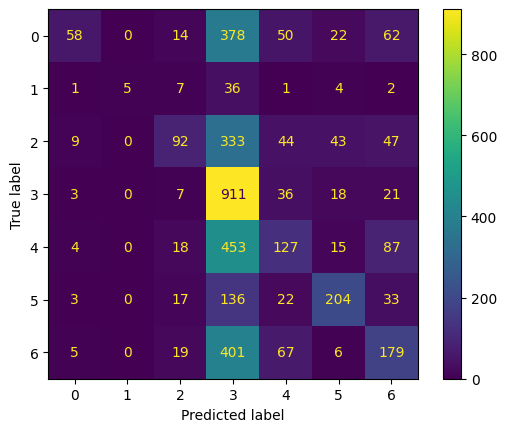

In [ ]:
# Plot confusion matrix for the best Random Forest model on PCA data
ConfusionMatrixDisplay(confusion_matrix=result_random_forest_pca_data_grid["Confusion matrix"],
                    display_labels=grid_search_pca_rf.classes_).plot()

### 5. CNN

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import warnings
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Input
from sklearn.metrics import classification_report
import seaborn as sns

In [ ]:
# Print the shapes of original scaled training and test data
print(X_train_orig_scaled.shape)
print(X_test_orig_scaled.shape)

(16000, 2304)
(4000, 2304)


In [ ]:
# One-hot encode the 'emotion' column with 7 possible classes
labels = to_categorical(df[['emotion']], num_classes=7)

# Display the one-hot encoded labels
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [ ]:
# Convert the 'pixels' column to strings, split each string by spaces into lists, and convert to a list of lists
train_pixels = df["pixels"].astype(str).str.split(" ").tolist()

# Convert the list of lists to an unsigned 8-bit integer numpy array
train_pixels = np.uint8(train_pixels)

# Display the resulting array
train_pixels

array([[ 70,  80,  82, ..., 106, 109,  82],
       [151, 150, 147, ..., 193, 183, 184],
       [231, 212, 156, ...,  88, 110, 152],
       ...,
       [ 63,  43,  25, ...,   4,   7,   5],
       [ 84,  48,  49, ..., 235, 244, 242],
       [114, 115, 115, ..., 125, 106, 116]], dtype=uint8)

In [ ]:
# Reshape the array X to have dimensions (number of samples, 48, 48, 1)
pixels = X.reshape((len(X), 48, 48, 1))

In [ ]:
# Create an ImageDataGenerator for augmenting training images with specified transformations
datagen = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True, zoom_range = 0.2)

# Create another ImageDataGenerator for augmenting validation images with the same transformations
valgen = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True, zoom_range = 0.2)

In [ ]:
# Split the data into training and testing sets, with 20% of the data reserved for testing
# The shuffle=False parameter ensures the data is not shuffled before splitting
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.2, shuffle=False)

# Further split the training set into training and validation sets, with 20% of the training data reserved for validation
# The shuffle=False parameter ensures the data is not shuffled before splitting
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [ ]:
# Fit the training data generator to the training data
datagen.fit(X_train)

# Fit the validation data generator to the validation data
valgen.fit(X_val)

In [ ]:
# Create a generator for training data with batch size of 64
train_generator = datagen.flow(X_train, y_train, batch_size=64)

# Create a generator for validation data with batch size of 64
val_generator = datagen.flow(X_val, y_val, batch_size=64)

In [ ]:
### CNN model

def cnn_model():
    """
    Creates a Convolutional Neural Network (CNN) model for image classification.

    Returns:
        model (tf.keras.models.Sequential): CNN model for image classification.
    """
    model= tf.keras.models.Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
    model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(512,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(7, activation='softmax'))
    model.compile(
        optimizer = Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
# Create the CNN model
model = cnn_model()  # Initialize the CNN model for image classification

In [ ]:
# Display the summary of the model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,810,183 (22.16 MB)

 Trainable params: 5,805,191 (22.15 MB)

 Non-trainable params: 4,992 (19.50 KB)

In [ ]:
# Adding checkpointer to implement Early Stopping to prevent overfitting.
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, restore_best_weights=True, mode="max",patience = 5),
                ModelCheckpoint('best_model.keras',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [ ]:
# Train the model CNN
history = model.fit(train_generator, 
                    epochs=30,
                    batch_size=64,
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1646 - loss: 14.8438
Epoch 1: val_accuracy improved from -inf to 0.21875, saving model to best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.1646 - loss: 14.8426 - val_accuracy: 0.2188 - val_loss: 13.6173
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1885 - loss: 13.9394
Epoch 2: val_accuracy improved from 0.21875 to 0.24906, saving model to best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.1885 - loss: 13.9384 - val_accuracy: 0.2491 - val_loss: 13.0416
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2044 - loss: 13.1014
Epoch 3: val_accuracy improved from 0.24906 to 0.26469, saving model to best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.2043 - loss: 13.1004 - val_accuracy: 0.2647 - val_loss: 12.1784
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2152 - loss: 12.2348
Epoch 4: val_accuracy did not im

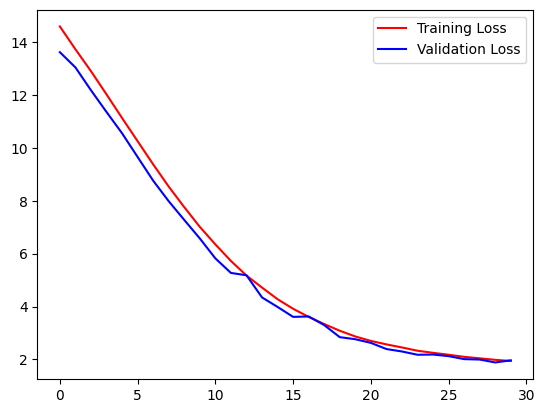

In [ ]:
# Plot training and validation loss
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")

# Add labels and title to the plot
plt.legend()

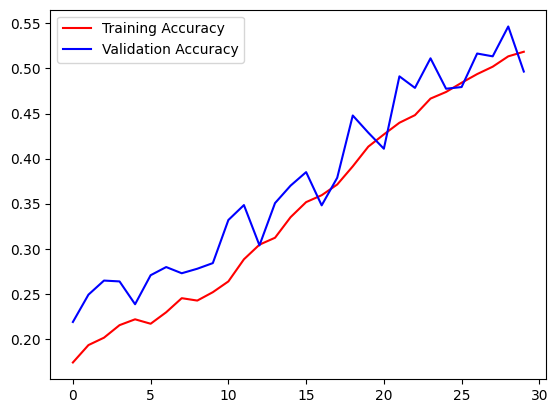

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")

# Add labels and title to the plot
plt.legend()

In [ ]:
# Evaluate the model on test data
loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))

125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - accuracy: 0.5754 - loss: 1.8091
Test Acc: 0.5707499980926514


In [ ]:
# Predict labels for test data
preds = model.predict(X_test)

# Get predicted labels
y_pred = np.argmax(preds , axis = 1 )

125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step


In [ ]:
# Print classification report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.423     0.547     0.477       523
           1      0.750     0.060     0.111        50
           2      0.470     0.142     0.218       549
           3      0.732     0.856     0.789      1024
           4      0.451     0.405     0.427       691
           5      0.677     0.732     0.703       466
           6      0.503     0.600     0.547       697

    accuracy                          0.571      4000
   macro avg      0.572     0.477     0.468      4000
weighted avg      0.561     0.571     0.547      4000



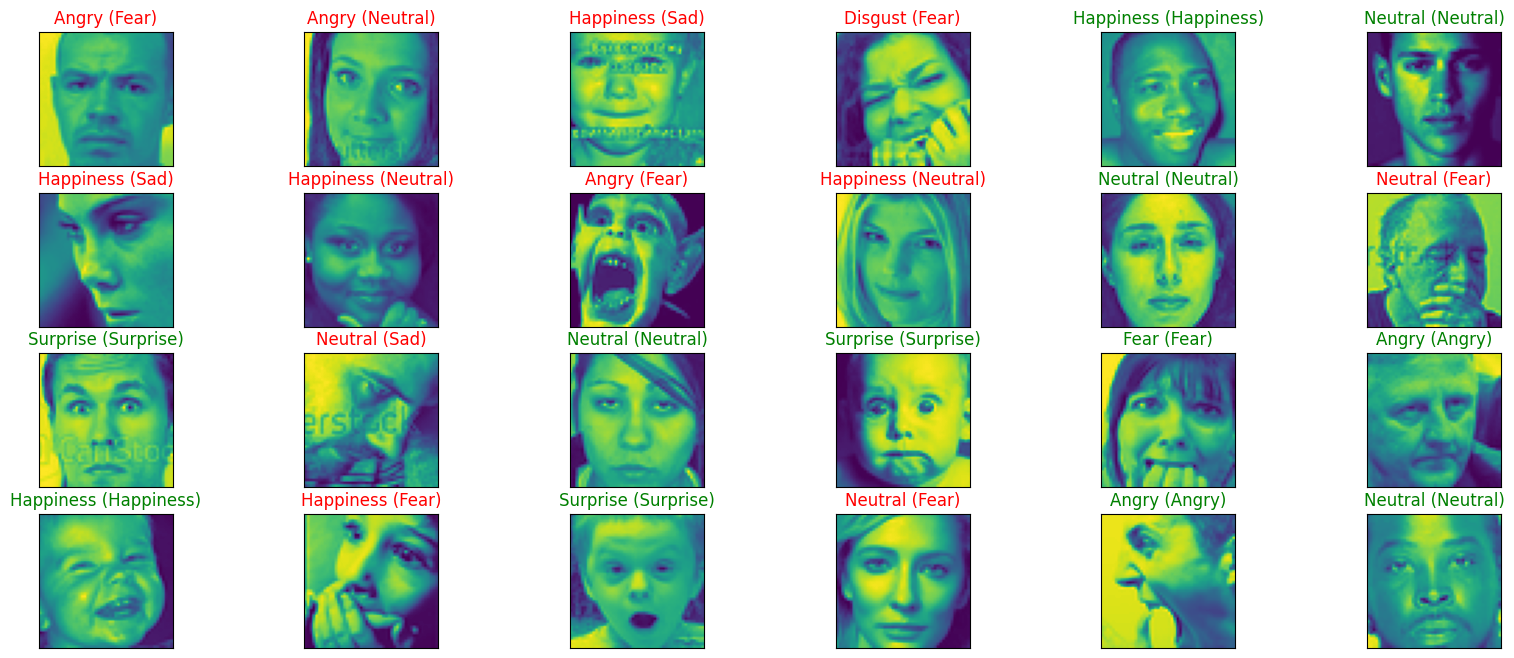

In [ ]:
# Dictionary mapping class indices to class labels
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

# Create a figure to display the grid of images
figure = plt.figure(figsize=(20, 8))

# Iterate over randomly selected indices from the test set
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    # Add a subplot for each image in the grid
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])

    # Display the image
    ax.imshow(np.squeeze(X_test[index]))

    # Get the predicted and true labels for the current image
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]

    # Set the title of the subplot with the predicted and true labels
    # The title color is set to green if the prediction is correct, red otherwise
    ax.set_title("{} ({})".format((predict_index),
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

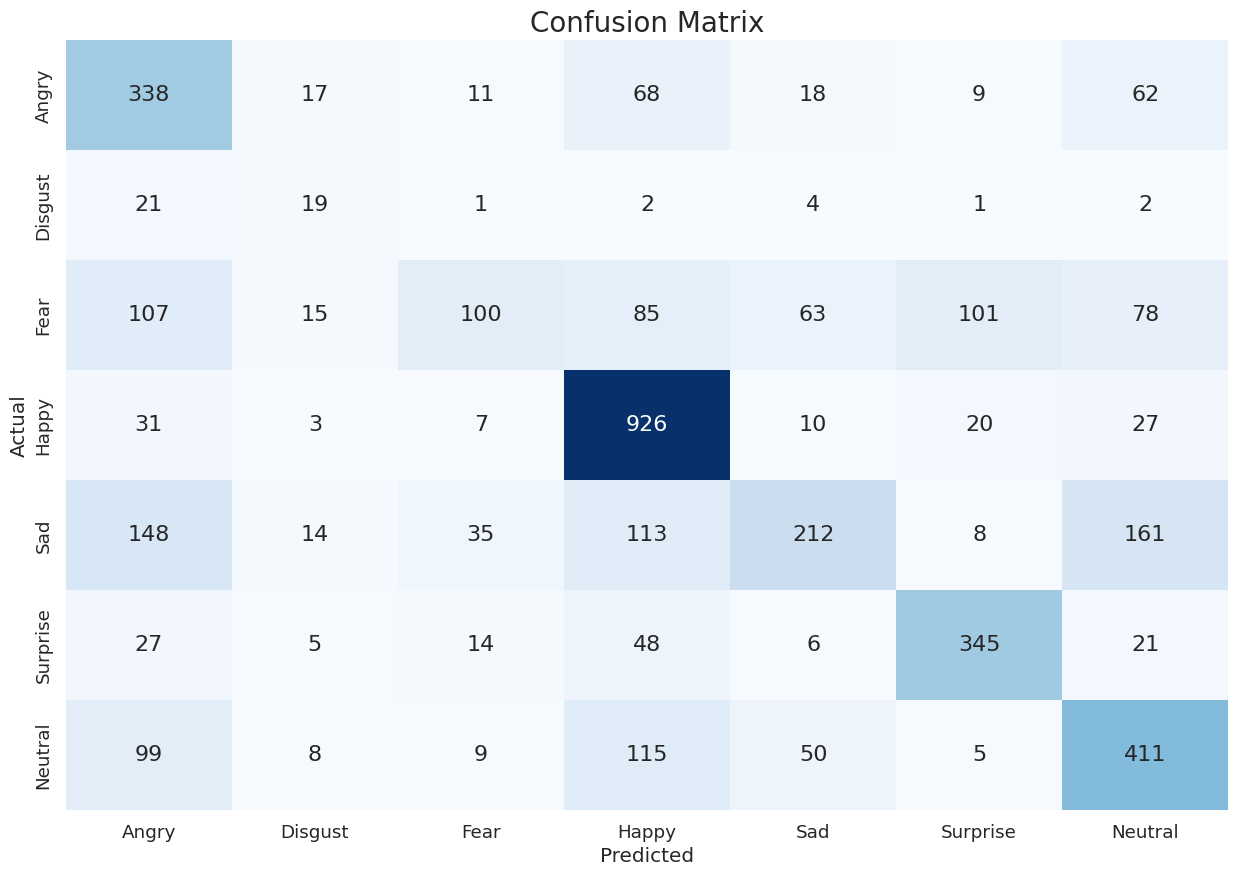

In [ ]:
# Define the labels for the classes
CLASS_LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', "Surprise", 'Neutral']

# Generate a confusion matrix from the test data and the predicted data
cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)

# Convert the confusion matrix data into a pandas DataFrame
# Set the column names and the index names to the class labels
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)

# Set the index name to 'Actual'
cm.index.name = 'Actual'

# Set the column name to 'Predicted'
cm.columns.name = 'Predicted'

# Create a new figure with a specific size
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)

# Create a heatmap from the confusion matrix
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [ ]:
# Initialize the Convolutional Neural Network (CNN) model
model = cnn_model()

In [ ]:
# Compile the CNN model with the specified optimizer, loss function, and metrics
model.compile(
        optimizer = Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

In [ ]:
# Adding checkpointer to implement Early Stopping to prevent overfitting.
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, restore_best_weights=True, mode="max",patience = 5),
                ModelCheckpoint('best_model.keras',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [ ]:
# Train the CNN model using the training data generator
history = model.fit(train_generator,
                    epochs=50,
                    batch_size=64,
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1542 - loss: 14.8457
Epoch 1: val_accuracy improved from -inf to 0.18750, saving model to best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.1543 - loss: 14.8446 - val_accuracy: 0.1875 - val_loss: 13.7587
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1813 - loss: 14.0021
Epoch 2: val_accuracy improved from 0.18750 to 0.23656, saving model to best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.1813 - loss: 14.0011 - val_accuracy: 0.2366 - val_loss: 13.0440
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2051 - loss: 13.1893
Epoch 3: val_accuracy improved from 0.23656 to 0.25438, saving model to best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.2051 - loss: 13.1883 - val_accuracy: 0.2544 - val_loss: 12.2977
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2002 - loss: 12.3762
Epoch 4: val_accuracy did not im

In [ ]:
# Evaluate the model's performance on the test data
loss = model.evaluate(X_test,y_test)

# Print the model's accuracy on the test data
print("Test Acc: " + str(loss[1]))

125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.5838 - loss: 1.6450
Test Acc: 0.5877500176429749


In [ ]:
# Use the model to predict the class labels for the test data
preds = model.predict(X_test)

# Convert the predicted probabilities to class labels
y_pred = np.argmax(preds , axis = 1 )

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step


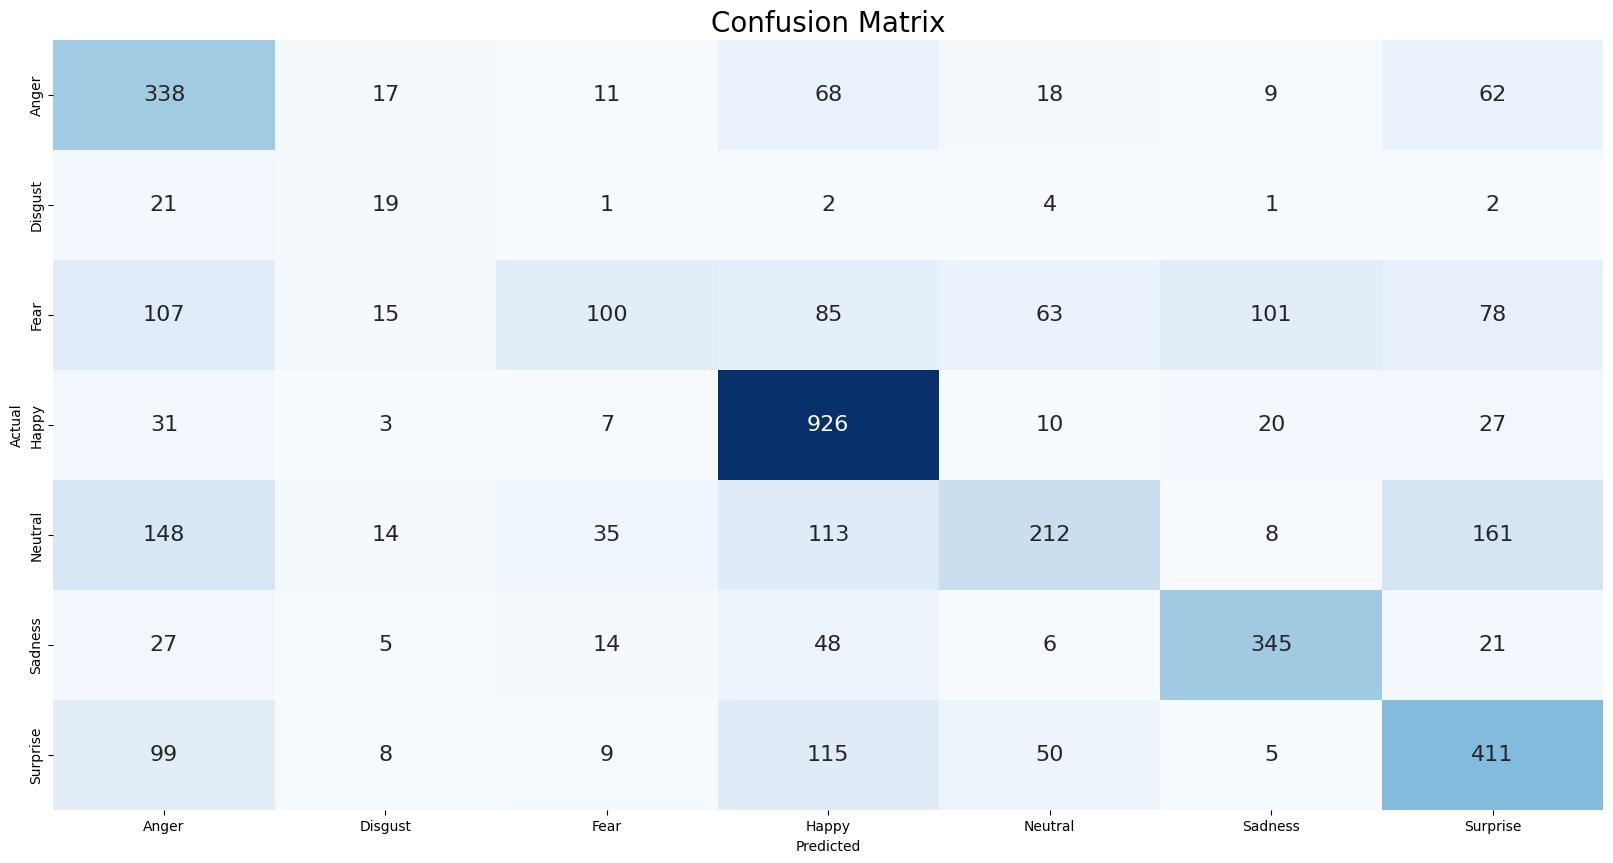

In [ ]:
# Define the labels for the classes
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

# Generate a confusion matrix from the test data and the predicted data
cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)

# Convert the confusion matrix data into a pandas DataFrame
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)

# Set the index name to 'Actual'
cm.index.name = 'Actual'

# Set the column name to 'Predicted'
cm.columns.name = 'Predicted'

# Create a new figure with a specific size
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)

# Create a heatmap from the confusion matrix
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [ ]:
# print classification report
print(classification_report(np.argmax(y_test, axis = 1), y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.438     0.646     0.522       523
           1      0.235     0.380     0.290        50
           2      0.565     0.182     0.275       549
           3      0.682     0.904     0.778      1024
           4      0.584     0.307     0.402       691
           5      0.706     0.740     0.723       466
           6      0.539     0.590     0.563       697

    accuracy                          0.588      4000
   macro avg      0.536     0.536     0.508      4000
weighted avg      0.590     0.588     0.561      4000



---

## 4. Compare the performance of 4 different classification algorithms

Bảng so sánh 4 mô hình Logistic Regression, SVM, MLP và Decision Tree (có thêm CNN) trên dữ liệu gốc:

|      Mô hình          | Accuracy | Macro avg F1-score | Weighted avg F1-score | Đánh giá |
|:---------------------:|:--------:|:------------------:|:---------------------:|:--------:|
| Logistic Regression   |   0.30   |        0.26        |         0.30          | Cho thấy kết quả tương đối thấp so với các mô hình khác, đặc biệt là trên các lớp thiểu số. |
| SVM                   |   0.43   |        0.35        |         0.41          | Đạt được độ chính xác cao và khả năng phân loại tốt hơn các lớp khác nhau, dù kết quả recall và precision trên lớp 1 có thể không được cao. |
| MLP                   |   0.38   |        0.34        |         0.38          | Kết quả tương đối trung bình, không vượt trội so với các mô hình khác. |
| Decision Tree         |   0.42   |        0.38        |         0.40          | Đạt được kết quả F1-score cao hơn so với Logistic Regression và MLP, nhưng vẫn thấp hơn SVM. |
|        CNN         |  0.588   |        0.508       |         0.561         | |

#### Giải thích:
- **Accuracy**: Độ chính xác của mô hình trên tập dữ liệu kiểm tra.
- **Macro avg f1-score**: Trung bình F1-score của tất cả các lớp, không phụ thuộc vào số lượng mẫu của từng lớp.
- **Weighted avg f1-score**: Trung bình F1-score của tất cả các lớp, có tính đến số lượng mẫu của từng lớp.

#### So sánh
- **Accuracy**: SVM đạt độ chính xác cao nhất (0.43), theo sau là Decision Tree (0.42), MLP (0.38) và Logistic Regression (0.30).
- **Macro avg f1-score**: SVM vẫn là tốt (0.35), Decision Tree (0.38), MLP (0.34), và cuối cùng là Logistic Regression (0.26).
- **Weighted avg f1-score**: SVM dẫn đầu (0.41), theo sau là Decision Tree (0.40), MLP (0.38), và Logistic Regression (0.30).

#### Đánh giá về các model
   - **SVM** có sự phân loại tốt hơn nhiều so với các mô hình khác, mặc dù có sự bất cập trên lớp thiểu số.
   - **Logistic Regression** và **MLP** cho thấy hiệu suất chủ yếu tập trung vào các lớp đa dạng và không thực sự đồng đều, dẫn đến kết quả chưa tốt.
   - **Decision Tree** cũng cho thấy khả năng phân loại khá tốt, nhưng có thể không hiệu quả như SVM trong các tình huống dữ liệu phức tạp hơn.

#### Kết luận
Dựa trên các chỉ số trên, **SVM (Support Vector Machine)** là mô hình có performance tốt nhất trong 4 mô hình Logistic Regression, SVM, MLP và Decision Tree khi xét đến độ chính xác, macro avg f1-score và weighted avg f1-score. SVM có khả năng phân loại và dự đoán chính xác hơn so với các 4 mô hình nêu trên trong bộ dữ liệu gốc này. Tuy nhiên performance mô hình SVM không cao nên nhóm em có tìm hiểu và thực hiện model CNN có kết quả khả quan hơn so với SVM.

---

Bảng so sánh 4 mô hình Logistic Regression, SVM, MLP và Decision Tree trên dữ liệu đã được PCA (Principal Component Analysis) chuyển đổi:

|      Mô hình          | Accuracy | Macro avg F1-score | Weighted avg F1-score | Đánh giá |
|:---------------------:|:--------:|:------------------:|:---------------------:|:--------:|
| Logistic Regression   |   0.37   |        0.29        |         0.34          | Độ chính xác cao hơn so với dữ liệu gốc nhưng vẫn cho kết quả thấp. |
| SVM                   |   0.45   |        0.37        |         0.42          | Cải thiện đáng kể so với dữ liệu gốc, đạt được độ chính xác và F1-score tốt nhất. |
| MLP                   |   0.35   |        0.31        |         0.35          | Kết quả chưa thay đổi nhiều so với dữ liệu gốc, vẫn cho thấy hiệu suất trung bình. |
| Random Forest         |   0.39   |        0.33        |         0.36          | Có cải thiện so với dữ liệu gốc nhưng vẫn thấp hơn SVM. |


#### So sánh
- **Accuracy**: SVM đạt độ chính xác cao nhất (0.45), theo sau là Random Forest (0.39), MLP (0.35) và Logistic Regression (0.37).
- **Macro avg f1-score**: SVM vẫn là tốt nhất (0.37), Random Forest (0.33), MLP (0.31), và cuối cùng là Logistic Regression (0.29).
- **Weighted avg f1-score**: SVM dẫn đầu (0.42), Random Forest (0.36), MLP (0.35), và Logistic Regression (0.34).

### Đánh giá về các mô hình:
- **Logistic Regression**: Cho thấy kết quả tương đối thấp so với các mô hình khác, đặc biệt là trên các lớp thiểu số.
- **SVM**: Đạt được độ chính xác cao và khả năng phân loại tốt hơn các lớp khác nhau, dù kết quả recall và precision trên lớp 1 có thể không được cao.
- **MLP**: Kết quả tương đối trung bình, không vượt trội so với các mô hình khác.
- **Random Forest**: Cho kết quả cải thiện so với dữ liệu gốc, tương đối ổn định, hưng không đạt được kết quả bằng SVM trên cùng tập dữ liệu.

### Kết luận
Dựa trên các chỉ số trên, **SVM (Support Vector Machine)** là mô hình có performance tốt nhất trong 4 mô hình Logistic Regression, SVM, MLP và Random Forest khi xét đến độ chính xác, macro avg f1-score và weighted avg f1-score trên dữ liệu đã được PCA (Principal Component Analysis) chuyển đổi. SVM có khả năng phân loại và dự đoán chính xác hơn so với các mô hình còn lại trong bộ dữ liệu này.

**Lý do chọn F1-score thay vì Accuracy:**

- F1-score là chỉ số đánh giá cân bằng giữa precision và recall, đặc biệt quan trọng trong các trường hợp dữ liệu không cân bằng giữa các lớp. Và trong tập dữ liệu này, một lớp có thể chiếm ưu thế hơn các lớp khác, dẫn đến chỉ số accuracy không phản ánh đúng hiệu suất của mô hình trên các lớp thiểu số.

- Accuracy chỉ đo lường tỉ lệ dự đoán đúng trên toàn bộ tập dữ liệu mà không xét đến sự phân bố của các lớp. Có thể dẫn đến hiểu nhầm nếu một lớp chiếm ưu thế đáng kể.

=> Do đó nên nhóm em dựa vào số liệu của f1-score để đánh giá các model.

---

## 5. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)

#### 1. SVM là mô hình tốt nhất trong 3 mô hình (Logistic, MLP, Random Forest)
Dựa trên kết quả đánh giá, có thể thấy rằng SVM là mô hình tốt nhất trong ba mô hình phân loại đã thử nghiệm (Logistic Regression, Multi-Layer Perceptron (MLP), và Random Forest). Nhìn nhận thông qua (accuracy), độ chính xác trung bình (macro average precision), và F1-score trung bình (macro average F1-score).

#### 2. Giải thích tại sao SVM tốt hơn so với 3 mô hình trên
SVM (Support Vector Machine) có khả năng tối ưu hóa biên giữa các lớp, đặc biệt hiệu quả trong không gian nhiều chiều với các bộ dữ liệu có cấu trúc phức tạp và không phân bố tuyến tính. Dữ liệu ảnh là với các điểm ảnh (pixels) đảm bảo cấu trúc phức tạp, phi tuyến tính và độc lập với với nhau. Vì vậy:
- **Khả năng tìm kiếm hyperplane tốt nhất**: SVM tìm kiếm một hyperplane tốt nhất để phân tách các lớp, giúp giảm thiểu lỗi phân loại
- **Khả năng làm việc với dữ liệu phi tuyến tính**: SVM có thể sử dụng các kernel tricks để biến đổi dữ liệu phi tuyến tính thành không gian tuyến tính, giúp phân biệt các lớp hiệu quả hơn.
- **Hiệu quả với bộ dữ liệu nhỏ và phức tạp**: SVM thường hoạt động tốt với các bộ dữ liệu không quá lớn và có nhiều đặc trưng.
- **Giảm thiểu các lớp bị missclassify**: SVM cố gắng tìm một hyperplane tốt nhất để tránh việc các lớp bị phân loại sai.

#### 3. So sánh SVM trên dữ liệu gốc và dữ liệu qua PCA

Bảng so sánh giữa SVM trên dữ liệu gốc và SVM sau khi áp dụng PCA (chưa tuning qua Grid Search):

|      Mô hình          | Accuracy | Macro avg F1-score | Weighted avg F1-score |
|-----------------------|----------|--------------------|-----------------------|
| SVM trên dữ liệu gốc  |   0.43   |        0.35        |         0.41          |
| SVM sau khi PCA       |   0.45   |        0.37        |         0.42          |

#### Nhận xét:

1. **Độ chính xác (Accuracy)**:
   SVM sau khi áp dụng PCA có độ chính xác cao hơn so với SVM trên dữ liệu gốc (0.45 so với 0.43). Đây là một cải thiện nhỏ nhưng có ý nghĩa, cho thấy việc giảm chiều dữ liệu PCA có thể giúp mô hình SVM phân loại tốt hơn trên tập dữ liệu này.

2. **F1-score trung bình (Weighted avg F1-score)**:
   SVM sau khi PCA cho weighted avg F1-score là 0.42, còn SVM trên dữ liệu gốc là 0.41. Sự cải thiện này cho thấy PCA giúp cải thiện khả năng tổng hợp giữa precision và recall của SVM trên các lớp dữ liệu.

3. **Precision và Recall trên từng lớp**:
   SVM sau khi PCA thường có sự cân bằng hơn giữa precision và recall trên các lớp so với SVM trên dữ liệu gốc. Điều này có thể giải thích việc cải thiện trong weighted avg F1-score.

4. **Tổng quan về hiệu suất**:
   - SVM sau khi PCA cho thấy khả năng phân loại tốt hơn và có khả năng tổng hợp (generalization) tốt hơn so với SVM trên dữ liệu gốc.
   - PCA giúp giảm chiều dữ liệu và loại bỏ sự phụ thuộc tuyến tính, từ đó cải thiện khả năng của SVM trong việc tổng hợp thông tin và giảm thiểu overfitting.

Vì vậy, dựa trên sự so sánh này, SVM sau khi áp dụng PCA cho kết quả tốt hơn so với SVM trên dữ liệu gốc, đặc biệt là về độ chính xác và khả năng tổng hợp F1-score trên các lớp dữ liệu. Điều này khẳng định rằng việc giảm chiều dữ liệu bằng PCA là một chiến lược hữu ích để cải thiện hiệu suất của mô hình SVM trong bài toán phân loại này.

#### 4. Emotion được dự đoán tốt nhất và tệ nhất
Nhóm tụi em sử dụng Grid Search để cải thiện hyperparameters trên dữ liệu gốc và PCA thì emotion dự đoán tốt nhất và tệ nhất đều có kể quả như sau:
- **Emotion được dự đoán tốt nhất**:
  - **Emotion 3** có F1-score cao nhất, điều này cho thấy mô hình có khả năng phân loại tốt nhất cho cảm xúc này. Một lý do có thể là Emotion 3 có số lượng mẫu lớn nhất, giúp mô hình học được đặc trưng của lớp này tốt hơn và đạt được độ chính xác cao hơn.
- **Emotion được dự đoán tệ nhất**:
  - **Emotion 1** có F1-score thấp nhất. Điều này có thể do số lượng mẫu của Emotion 1 quá ít, dẫn đến việc mô hình không có đủ dữ liệu để học đặc trưng của lớp này một cách hiệu quả.

#### 5. Kết luận
SVM đã chứng minh là mô hình tốt nhất trong ba mô hình đã thử nghiệm, đặc biệt hiệu quả trong việc phân loại các nhãn cảm xúc với độ chính xác và F1-score tốt hơn. Tuy nhiên, để cải thiện kết quả đối với các lớp có ít mẫu hơn, có thể cần các kỹ thuật bổ sung như xử lý mất cân bằng dữ liệu hoặc thu thập thêm dữ liệu.
Và nếu trong trường hợp thực tế ta có có thể dùng phương pháp hạn chế như ta gom 1 cụm cảm xúc lại để tăng số lượng data sample như ghép angry với digust thành negative emotion chẳng hạn dù là không phân biệt chính xác nhưng có thể làm thêm 1 mô hình như phân biệt disgust và angry với việc chọn số lượng ảnh của disgust và angry bằng nhau thì bằng việc đi qua 2 lần thì sẽ phân biệt đc chính xác hơn.

---

### Nhận xét về mô hình CNN

#### 1. Tổng quan hiệu suất mô hình
Dựa trên kết quả đánh giá, mô hình CNN (Convolutional Neural Network) cho thấy hiệu suất khá tốt với độ chính xác tổng thể (accuracy) là 0.588. Các chỉ số đánh giá chi tiết như độ chính xác (precision), độ nhạy (recall), và F1-score cũng cho thấy mô hình có khả năng phân loại các nhãn cảm xúc khác nhau.

#### 2. Đánh giá chi tiết các nhãn cảm xúc
- **Emotion được dự đoán tốt nhất**:
  - **Emotion 3** có F1-score cao nhất là 0.778, với precision là 0.682 và recall là 0.904. Điều này cho thấy mô hình CNN có khả năng phân loại tốt nhất cho cảm xúc này. Emotion 3 có số lượng mẫu lớn nhất (1024), giúp mô hình học được đặc trưng của lớp này tốt hơn và đạt được hiệu suất cao trong việc nhận diện.
- **Emotion được dự đoán tệ nhất**:
  - **Emotion 2** có F1-score thấp nhất là 0.275. Mặc dù precision là 0.565, nhưng recall chỉ là 0.182, cho thấy mô hình gặp khó khăn trong việc nhận diện chính xác nhiều mẫu của cảm xúc này. Điều này có thể là do Emotion 2 có đặc trưng ít rõ ràng hoặc bị nhiễu loạn bởi các lớp khác.
  - **Emotion 1** cũng có hiệu suất thấp với F1-score là 0.290, precision là 0.235 và recall là 0.380. Mô hình gặp khó khăn trong việc phân loại chính xác cảm xúc này, có thể do số lượng mẫu quá ít (50), dẫn đến việc mô hình không có đủ dữ liệu để học đặc trưng của lớp này một cách hiệu quả.

#### 3. Giải thích tại sao mô hình CNN hoạt động tốt hơn
CNN giúp mô hình nhận diện được các mẫu hình ảnh nhỏ và sau đó kết hợp chúng để nhận diện các mẫu phức tạp hơn ở các lớp cao hơn. Thêm vào đó, CNN có khả năng học trên dữ liệu có cấu trúc không gian cao (như dữ liệu hình ảnh chẳng hạn).

### 4. Kết luận
Mô hình CNN đã cho thấy hiệu suất tốt trong việc phân loại các nhãn cảm xúc, đặc biệt là với các nhãn có số lượng mẫu lớn và đặc trưng rõ ràng.